In [1]:
import skxray.core.xsvs as xsvs
import skxray.core.xsvs_fitting as xsvs_fit
import skxray.core.roi as roi
import skxray.core.correlation as corr
import skxray.core.utils as core

import numpy as np
import os, sys

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm

:0: FutureWarning: IPython widgets are experimental and may change in the future.


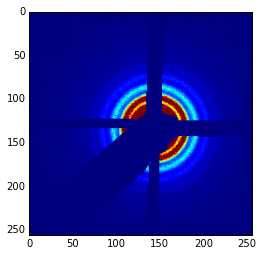

In [2]:
data_dir = "/Volumes/Data/BeamLines/CHX/Luxi_description_files_for_duke/duke_cc_12C/"
duke_ndata = np.load(data_dir+"duke_img_1_5000.npy")
duke_dark = np.load(data_dir+"duke_dark.npy")

duke_data = []
for i in range(duke_ndata.shape[0]):
    duke_data.append(duke_ndata[i] - duke_dark)
    
duke_data=np.asarray(duke_data)

avg_img = np.average(duke_data, axis=0)

mask4 = np.load("/Users/sameera/Desktop/XSVS/new_mask4.npy")
mask = np.load("/Users/sameera/Desktop/XSVS/Luxi_data/Luxi_duke_mask.npy")

N_mask = ~(mask + mask4)

plt.imshow(N_mask*avg_img, vmax=1e0)
plt.show()

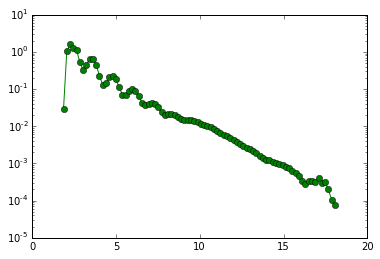

In [3]:
est_center = (133, 143)   

inner_radius = 25
width = 5
var = 20

bin_centers, ring_averages= roi.circular_average(avg_img*N_mask, est_center, threshold=0, nx=100,
                                         pixel_size=(0.1, 0.1))
line_color="green"
line_style='o'
plt.semilogy(bin_centers, ring_averages, c=line_color, marker=line_style )
plt.show()

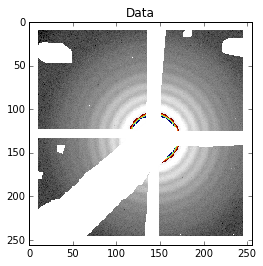

In [4]:
inner_radius = 26
width = 1
spacing = 0
num_rings = 4

edges = roi.ring_edges(inner_radius, width, spacing, num_rings)

rings = roi.rings(edges, (133, 143), avg_img.shape)

rings_mask = rings*N_mask

mask_data1 = N_mask*duke_data[0:2655]
mask_data2 = N_mask*duke_data[2659:4999]

def test_demo(ax, label_array, img_dim, image):
    """
    This will plot the reqiured roi's on the image
    """

    vmin, vmax = np.percentile(image, [100, 100])
    #im = ax.imshow(tt.reshape(*img_dim), cmap='Paired', interpolation='nearest')
    im = ax.imshow(image, cmap='gist_gray', interpolation='none', norm=LogNorm(), vmax=1e0)
    im = ax.imshow(label_array, interpolation='none', norm=LogNorm())
    #im = ax.imshow(image, interpolation='none',  vmax=1e0)
    
#  get the avearge image of the data set
avg_img = np.average(mask_data1, axis=0)
    
fig, ax = plt.subplots()
plt.title("Data")
test_demo(ax, rings_mask, avg_img.shape, avg_img)
plt.show()


In [5]:
dpix =0.055

lambda_ = 1.5498  # wavelength
Ldet = 2200.   #   # distance to sample

edges

array([[ 26.,  27.],
       [ 27.,  28.],
       [ 28.,  29.],
       [ 29.,  30.]])

In [6]:
two_theta = core.radius_to_twotheta(Ldet, edges*dpix)
q_val = core.twotheta_to_q(two_theta, lambda_)
q_val

array([[ 0.00263522,  0.00273658],
       [ 0.00273658,  0.00283793],
       [ 0.00283793,  0.00293929],
       [ 0.00293929,  0.00304064]])

In [7]:
q_cen = np.mean(q_val, axis=1)
q_cen

array([ 0.0026859 ,  0.00278726,  0.00288861,  0.00298997])

In [8]:
images_sets = (mask_data1, mask_data2)
max_cts = roi.roi_max_counts(images_sets, rings_mask)
max_cts

24

In [9]:
spe_cts_all1, std_dev1 = xsvs.xsvs(images_sets, rings_mask, timebin_num=2,
                             number_of_img=8, max_cts=24)

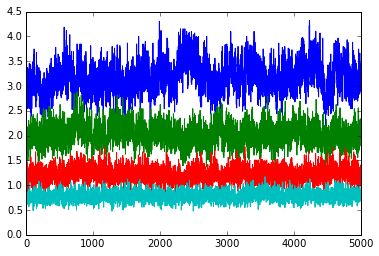

array([ 3.17485961,  2.03201167,  1.22065947,  0.78540586])

In [10]:
mean_int_sets, index_list = roi.mean_intensity_sets(images_sets, rings_mask)
combine_intensity = roi.combine_mean_intensity(mean_int_sets, index_list)

plt.plot(combine_intensity)
plt.show()

mean_int_ring = np.mean(combine_intensity, axis=0)
mean_int_ring


In [11]:
num_times = 6
num_rois=num_rings
norm_bin_edges, norm_bin_centers = xsvs.normalize_bin_edges(num_times,
                                                            num_rois, mean_int_ring, max_cts=24)

In [12]:
norm_bin_edges[0,1].shape, spe_cts_all1[0, 1].shape

((24,), (23,))

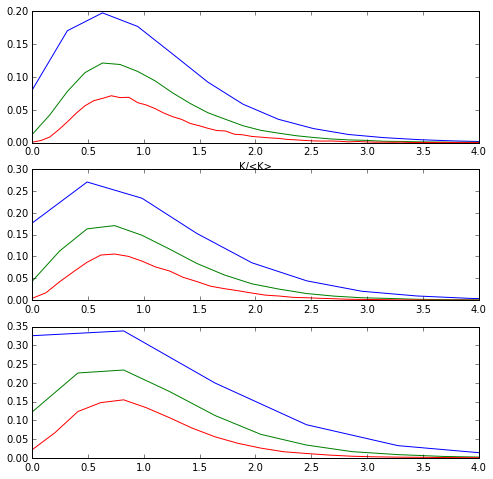

In [13]:
fig, axes = plt.subplots(3, figsize=(8, 8))
for j in range(3):
    axes[0].set_xlabel("K/<K>")
    for i in range(3):
        art, = axes[j].plot(norm_bin_edges[i, j][:-1], spe_cts_all1[i, j])
                                #yerr=std_dev[i, j], fmt='-o')
        #errorbar(norm_bin_edges[i, 0][:-1], spe_cts_all[i, 0], yerr=std_dev[i, 0],fmt='-o')
        axes[j].set_xlim(0, 4)
plt.show()

In [17]:
mean_int_ring

array([ 3.17485961,  2.03201167,  1.22065947,  0.78540586])

# Fitting for Ring 1

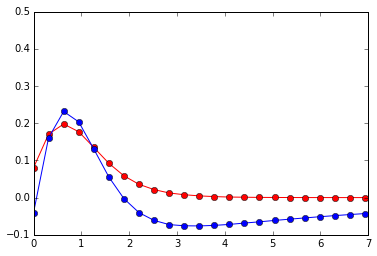

In [28]:
from lmfit import minimize, Parameters
# create a set of Parameters
params1 = Parameters()
params1.add('K',  value=3.5, min=2.3, max = 4.56)
params1.add('M',  value=1.2, min=0.88, max=2)

final_result1 = xsvs_fit.eval_binomal_dist(params1, norm_bin_edges[0, 0][:-1],
                                           spe_cts_all1[0, 0], err=1)

plt.plot(norm_bin_edges[0, 0][:-1], spe_cts_all1[0,0], '-ro')
plt.plot(norm_bin_edges[0, 0][:-1], final_result1 , '-bo')
plt.ylim(-0.10, 0.50)
plt.show()

In [38]:
mean_int_ring[0]**2

10.079733513797951

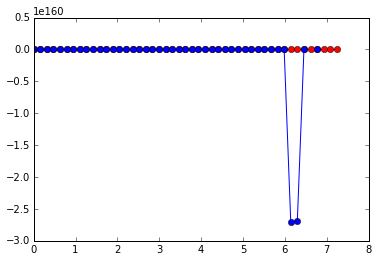

In [45]:
# create a set of Parameters
params2 = Parameters()
params2.add('K',  value=mean_int_ring[0]**2, min= 8.6, max= 12.2)
params2.add('M',  value=1.6, min=0.5, max=2.67)

final_result1 = xsvs_fit.eval_binomal_dist(params2, norm_bin_edges[1, 0][:-1],
                                           spe_cts_all1[1, 0], std_dev1[1, 0])

plt.plot(norm_bin_edges[1,0][:-1], spe_cts_all1[1,0], '-ro')
plt.plot(norm_bin_edges[1,0][:-1], final_result1 , '-bo')
#plt.ylim(-0.1, 0.5)
plt.show()

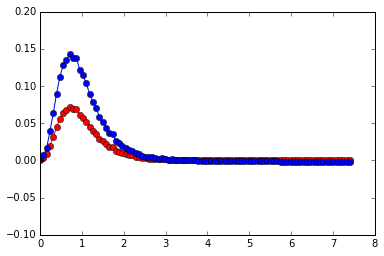

In [37]:
# create a set of Parameters
params4 = Parameters()
params4.add('K',  value=mean_int_ring[0]*8, min=0)
params4.add('M',  value=4.5, min=4.3, max=4.67)

final_result3 = xsvs_fit.eval_binomal_dist(params4, norm_bin_edges[2, 0][:-1],
                                           spe_cts_all1[2, 0], err=1)

plt.plot(norm_bin_edges[2, 0][:-1], spe_cts_all1[2, 0], '-ro')
plt.plot(norm_bin_edges[2, 0][:-1], final_result3, '-bo')
plt.ylim(-0.1, 0.2)
plt.show()